In [2]:
import os
import numpy as np
os.chdir('/import/home2/yhchenmath/Code/ucs/')
# No warning
import warnings
import tifffile
import h5py
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn
warnings.filterwarnings('ignore')
from downstream.utils import read_json_to_namespace

config = read_json_to_namespace("./downstream/config/xenium_breast_cancer.json")

method_list = ["UCS_10X", "Cell_10X"]

In [3]:
# Load mask and csv/anndata1
import tifffile
import pandas as pd
import scanpy as sc
from skimage.segmentation import find_boundaries

mask_dict = {}
df_dict = {}
ad_st_dict = {}
boundary_dict = {}
for method in method_list:
    mask = tifffile.imread(config.segmentation_results[method])
    df = pd.read_csv(os.path.join(config.output_dir, f"{method}_cell_feature.csv"), index_col=0)
    ad_st = sc.read_h5ad(f"{config.output_dir}/scVI_output/{method}/annotated_adata_st.h5ad")
    mask_dict[method] = mask
    boundary_dict[method] = find_boundaries(mask, mode='inner')
    df_dict[method] = df
    ad_st_dict[method] = ad_st

In [5]:
# Load other
he = tifffile.imread(config.he)
dapi = tifffile.imread(config.dapi)

gene_map = tifffile.imread(config.gene_map)
gene_map_sum = gene_map.sum(axis=2)
with open(config.gene_names, 'r') as f:
    gene_names = f.readlines()
gene_names = [x.strip() for x in gene_names]

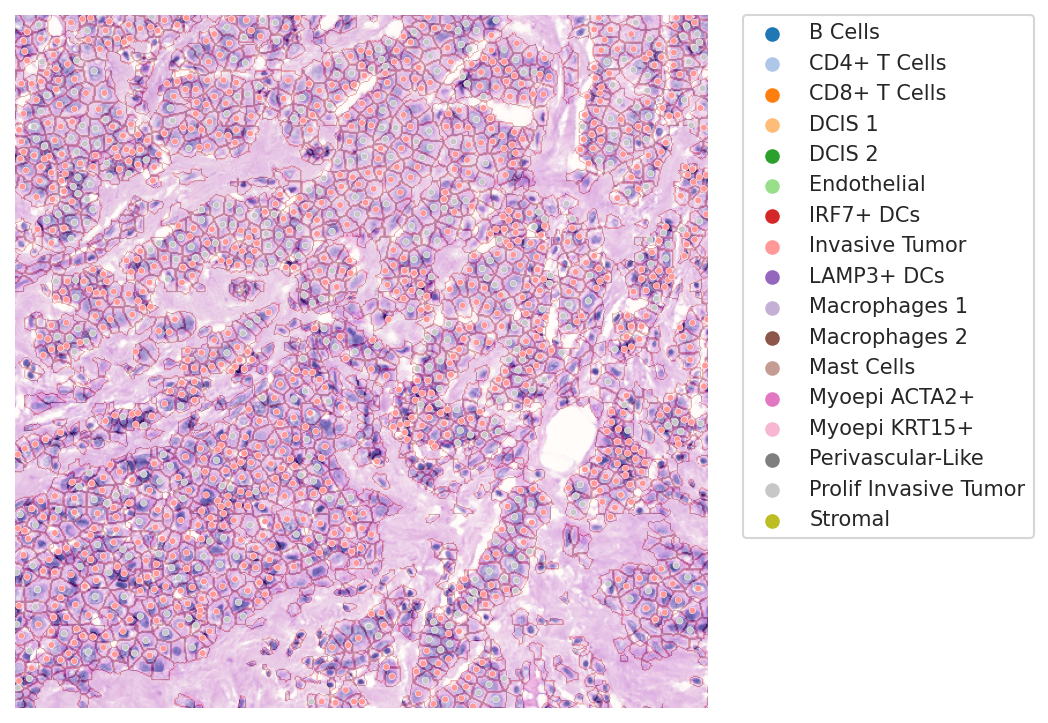

In [6]:
import numpy as np
# Plot all the cell and their cell type (by color) on the spatial map
# Small point
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
# Sorted by cell type
x_min, x_max, y_min, y_max = 1200, 1800, 2200, 2800
ad = ad_st_dict["UCS_10X"]
cell_roi = ad[
    (ad.obsm["spatial"][:, 0] > x_min) & (ad.obsm["spatial"][:, 0] < x_max) & (ad.obsm["spatial"][:, 1] > y_min) & (
                ad.obsm["spatial"][:, 1] < y_max) & (ad.obs["C_scANVI"].isin(["Invasive Tumor", "Prolif Invasive Tumor"]))]
plot_df = pd.DataFrame(cell_roi.obsm['spatial'], columns=['center_x', 'center_y'])
# Minus the x_min and y_min
plot_df['center_x'] = plot_df['center_x'] - x_min
plot_df['center_y'] = plot_df['center_y'] - y_min
plot_df['C_scANVI'] = cell_roi.obs['C_scANVI'].values
# Category of cell type
plot_df['C_scANVI'] = pd.Categorical(
    plot_df['C_scANVI'],
    categories=ad.obs['C_scANVI'].cat.categories,
    ordered=True
)
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=10, palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# imshow he and boundary of BIDCell
ax.imshow(he[:, x_min:x_max, y_min:y_max].transpose(1, 2, 0), aspect='auto')
# Gene Expression
# np.random.seed(5)
# pos_gene = pos_gene_df.loc["Myofibroblasts"].astype(bool) | pos_gene_df.loc["Fibroblasts"].astype(bool)
# for i in range(0, gene_map.shape[2]):
#     if pos_gene[i] > 0:
#         ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1],
#                    np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="red")
# pos_gene = pos_gene_df.loc['CD4Tconv/Treg'].astype(bool) | pos_gene_df.loc['CD8T/CD8Tex'].astype(bool)
# for i in range(0, gene_map.shape[2]):
#     if pos_gene[i] > 0:
#         ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1],
#                    np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="blue")
# Legend outside
# ax.scatter(0, 0, s=2, c="red", label="Fibroblasts gene")
# ax.scatter(0, 0, s=2, c="blue", label="T Cell gene")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# for i in range(0, gene_map.shape[2]):
#     ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=1, c=np.random.rand(3, ))
# Nuclei
# ax.imshow(mask_dict["Nuclei_10X"][x_min:x_max, y_min:y_max], cmap='Greens', alpha=0.6)
# Image boundary
ax.imshow(boundary_dict['UCS_10X'][x_min:x_max, y_min:y_max], cmap='Reds', alpha=0.3)
ax.set_axis_off()

In [7]:
df_sub_10X = pd.read_csv(f"{config.output_dir}/10X_subcellular.csv", index_col=0)
df_sub_ucs = pd.read_csv(f"{config.output_dir}UCS_subcellular.csv", index_col=0)
df_sub_10X.dropna(inplace=True)
df_sub_ucs.dropna(inplace=True)

In [8]:
top3_nucl_gene_ucs = df_sub_ucs[df_sub_ucs["top"] == "nuclear"]['gene'].value_counts()[:3]
top3_nucl_gene_10X = df_sub_10X[df_sub_10X["top"] == "nuclear"]['gene'].value_counts()[:3]
top3_cyto_gene_ucs = df_sub_ucs[df_sub_ucs["top"] == "cell_edge"]['gene'].value_counts()[:3]
top3_cyto_gene_10X = df_sub_10X[df_sub_10X["top"] == "cell_edge"]['gene'].value_counts()[:3]

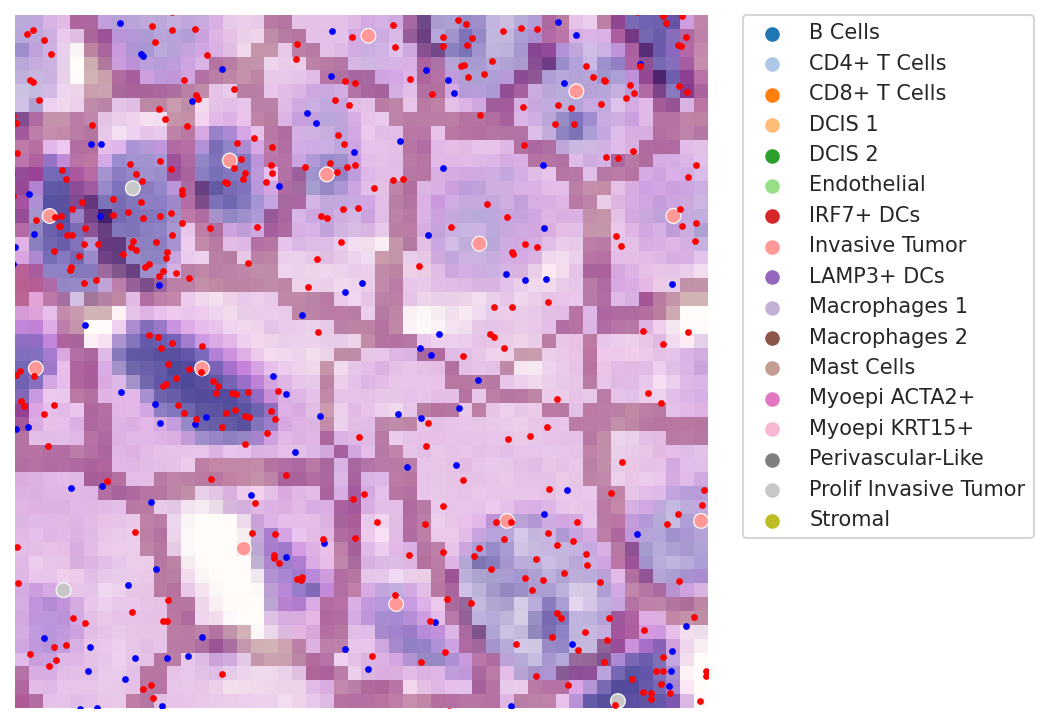

In [9]:
import numpy as np
# Plot all the cell and their cell type (by color) on the spatial map
# Small point
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
# Sorted by cell type
x_min, x_max, y_min, y_max = 1600, 1650, 2400, 2450
ad = ad_st_dict["UCS_10X"]
cell_roi = ad[
    (ad.obsm["spatial"][:, 0] > x_min) & (ad.obsm["spatial"][:, 0] < x_max) & (ad.obsm["spatial"][:, 1] > y_min) & (
                ad.obsm["spatial"][:, 1] < y_max) & (ad.obs["C_scANVI"].isin(["Invasive Tumor", "Prolif Invasive Tumor"]))]
plot_df = pd.DataFrame(cell_roi.obsm['spatial'], columns=['center_x', 'center_y'])
# Minus the x_min and y_min
plot_df['center_x'] = plot_df['center_x'] - x_min
plot_df['center_y'] = plot_df['center_y'] - y_min
plot_df['C_scANVI'] = cell_roi.obs['C_scANVI'].values
# Category of cell type
plot_df['C_scANVI'] = pd.Categorical(
    plot_df['C_scANVI'],
    categories=ad.obs['C_scANVI'].cat.categories,
    ordered=True
)
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=50, palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# imshow he and boundary of BIDCell
ax.imshow(he[:, x_min:x_max, y_min:y_max].transpose(1, 2, 0), aspect='auto')
# Gene Expression
ax.scatter(df_sub_ucs[df_sub_ucs["top"] == "cell_edge"]["x"] - (y_min-2200), df_sub_ucs[df_sub_ucs["top"] == "cell_edge"]["y"]- (x_min-1200), s=5, c="blue")
ax.scatter(df_sub_ucs[df_sub_ucs["top"] == "nuclear"]["x"] - (y_min-2200), df_sub_ucs[df_sub_ucs["top"] == "nuclear"]["y"]- (x_min-1200), s=5, c="red")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# for i in range(0, gene_map.shape[2]):
#     ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=1, c=np.random.rand(3, ))
# Nuclei
# ax.imshow(mask_dict["Nuclei_10X"][x_min:x_max, y_min:y_max], cmap='Greens', alpha=0.6)
# Image boundary
ax.imshow(boundary_dict['UCS_10X'][x_min:x_max, y_min:y_max], cmap='Reds', alpha=0.3)
ax.set_axis_off()  # Subcellular

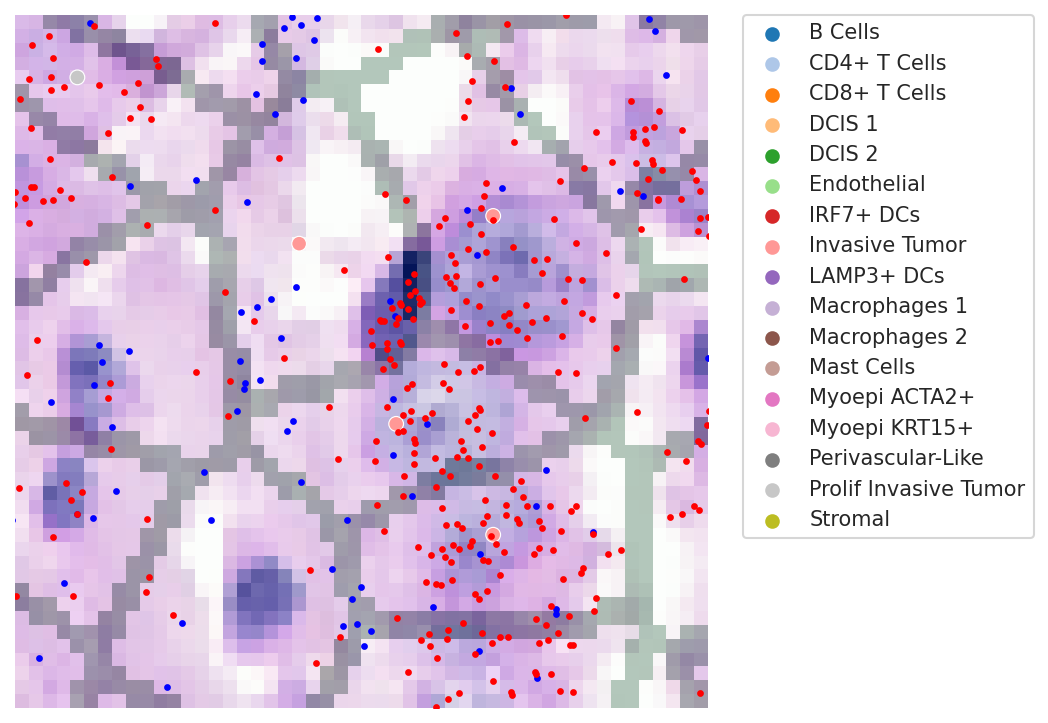

In [10]:
import numpy as np
# Plot all the cell and their cell type (by color) on the spatial map
# Small point
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
# Sorted by cell type
x_min, x_max, y_min, y_max = 1450, 1500, 2750, 2800
ad = ad_st_dict["Cell_10X"]
cell_roi = ad[
    (ad.obsm["spatial"][:, 0] > x_min) & (ad.obsm["spatial"][:, 0] < x_max) & (ad.obsm["spatial"][:, 1] > y_min) & (
                ad.obsm["spatial"][:, 1] < y_max) & (ad.obs["C_scANVI"].isin(["Invasive Tumor", "Prolif Invasive Tumor"]))]
plot_df = pd.DataFrame(cell_roi.obsm['spatial'], columns=['center_x', 'center_y'])
# Minus the x_min and y_min
plot_df['center_x'] = plot_df['center_x'] - x_min
plot_df['center_y'] = plot_df['center_y'] - y_min
plot_df['C_scANVI'] = cell_roi.obs['C_scANVI'].values
# Category of cell type
plot_df['C_scANVI'] = pd.Categorical(
    plot_df['C_scANVI'],
    categories=ad.obs['C_scANVI'].cat.categories,
    ordered=True
)
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=50, palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# imshow he and boundary of BIDCell
ax.imshow(he[:, x_min:x_max, y_min:y_max].transpose(1, 2, 0), aspect='auto')
# Gene Expression
ax.scatter(df_sub_10X[df_sub_10X["top"] == "cell_edge"]["x"] - (y_min-2200), df_sub_10X[df_sub_10X["top"] == "cell_edge"]["y"]- (x_min-1200), s=5, c="blue")
ax.scatter(df_sub_10X[df_sub_10X["top"] == "nuclear"]["x"] - (y_min-2200), df_sub_10X[df_sub_10X["top"] == "nuclear"]["y"]- (x_min-1200), s=5, c="red")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# for i in range(0, gene_map.shape[2]):
#     ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=1, c=np.random.rand(3, ))
# Nuclei
# ax.imshow(mask_dict["Nuclei_10X"][x_min:x_max, y_min:y_max], cmap='Greens', alpha=0.6)
# Image boundary
ax.imshow(boundary_dict['Cell_10X'][x_min:x_max, y_min:y_max], cmap='Greens', alpha=0.3)
ax.set_axis_off()  # Subcellular

<Axes: xlabel='gene'>

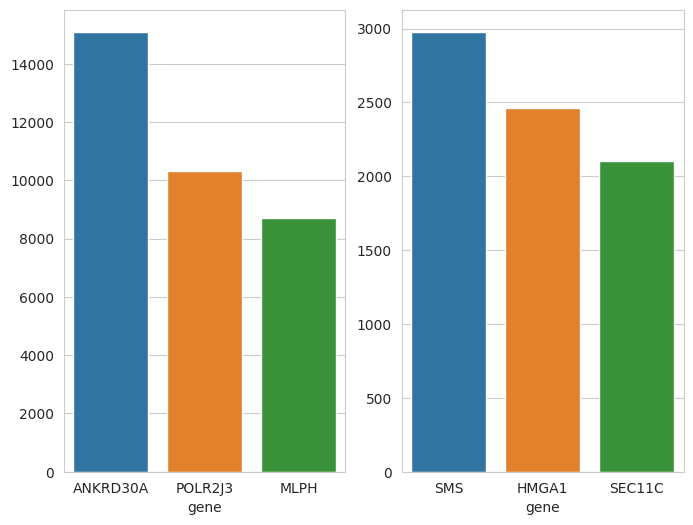

In [11]:
fig, ax = plt.subplots(1,2, figsize=(8, 6))
sns.barplot(x=top3_nucl_gene_ucs.index, y=top3_nucl_gene_ucs.values, ax=ax[0])
sns.barplot(x=top3_cyto_gene_ucs.index, y=top3_cyto_gene_ucs.values, ax=ax[1])

<Axes: xlabel='gene'>

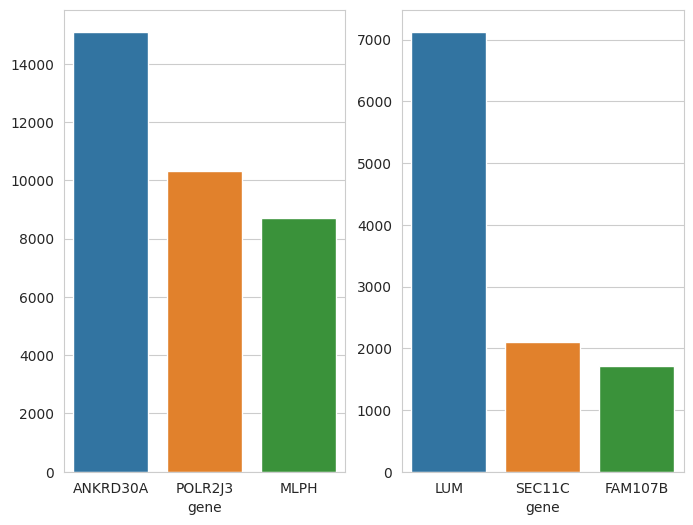

In [12]:
fig, ax = plt.subplots(1,2, figsize=(8, 6))
sns.barplot(x=top3_nucl_gene_10X.index, y=top3_nucl_gene_10X.values, ax=ax[0])
sns.barplot(x=top3_cyto_gene_10X.index, y=top3_cyto_gene_10X.values, ax=ax[1])

In [14]:
# SCRNA
ad_sc = sc.read_h5ad(f"{config.output_dir}/scVI_output/UCS_10X/adata.h5ad")
# Tech = sc
ad_sc = ad_sc[ad_sc.obs["tech"] == "sc"]

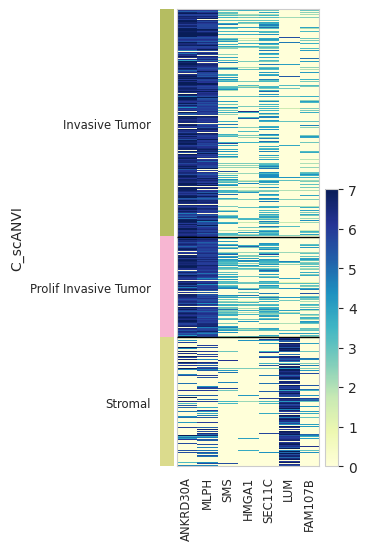

In [15]:
adata = ad_sc.copy()
adata.X = adata.layers["counts"]
gene_list = ["ANKRD30A", "MLPH", "SMS", "HMGA1", "SEC11C", "LUM", "FAM107B"] # ad_st_dict["USC SBG 10X"].var.index
# Only show invasive tumor and Prolif Invasive Tumor
adata = adata[adata.obs["C_scANVI"].isin(["Stromal","Invasive Tumor", "Prolif Invasive Tumor"])]
sc.pl.heatmap(adata,gene_list, groupby='C_scANVI', cmap='YlGnBu', show_gene_labels=True, vmax=7)